In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path

sys.path.append(os.path.join(Path().resolve(), '../../../../..'))

import numpy as np
from tqdm import tqdm

import hydra
from omegaconf import DictConfig, OmegaConf
import torch


/home/docker/.pyenv/versions/3.8.0/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 勾配を計算しない
torch.set_grad_enabled(False)

In [3]:
%matplotlib inline
# %matplotlib notebook
# %matplotlib nbagg
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ArtistAnimation

import numpy as np
from tqdm import tqdm

In [4]:

model_folder = "results/KL-Min-IL-prior-RSSM-uniform/2022-08-25/run_0"
model_folder = "results/KL-Min-IL-prior-T_2-500_experts-seed_0-RSSM-500_experts-500_uniforms-seed_0-fix/2022-10-01/run_0"

model_folder = "results/BC_mse-RSSM-T_2-500_experts-seed_0-RSSM-0_experts-1000_uniforms-seed_0-fix/2022-09-30/run_0"

In [5]:
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
with initialize(config_path=model_folder):
    cfg = compose(config_name="hydra_config")

cfg_device = "cuda:0"
# cfg_device = "cpu"
cfg.main.device = cfg_device
cfg.main.wandb = False
# cfg.train.n_episode = 100
print(' ' * 26 + 'Options')
for k, v in cfg.items():
    print(' ' * 26 + k + ': ' + str(v))

/tmp/ipykernel_56396/3531340990.py:3: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path=model_folder):


                          Options
                          main: {'experiment_name': 'BC_mse-RSSM-T_2-500_experts-seed_0-RSSM-0_experts-1000_uniforms-seed_0-fix', 'tags': ['IL', 'BC', 'BC-RSSM', 'BC_mse-RSSM', 'fix-RSSM'], 'log_dir': '/home/docker/sharespace/MultimodalRSSM/train/DMControlSuite/Reacher_easy/IL/BC_mse-RSSM/results/BC_mse-RSSM-T_2-500_experts-seed_0-RSSM-0_experts-1000_uniforms-seed_0-fix/2022-09-30/run_0', 'algo': 'IL', 'seed': 0, 'disable_cuda': False, 'device': 'cuda:0', 'test': False, 'test_interval': 1000, 'test_episodes': 5, 'validation_interval': 10, 'checkpoint_interval': 5000, 'checkpoint_experience': False, 'models': '', 'mlflow': False, 'wandb': False, 'git_hash': 'ced353a'}
                          env: {'env_config': {'env_name': 'reacher-easy', 'horizon': 1000}, 'taskset_name': 'dm_control', 'info_names': [], 'symbolic_env': False, 'observation_shapes': {'image': [3, 64, 64]}, 'action_name': 'action', 'action_size': 2, 'action_repeat': 4, 'episodes': 1000,

In [6]:
device = torch.device(cfg.main.device)
# device = torch.device("cpu")

In [7]:
dataset_dir = cfg.train.experience_replay

In [8]:
from algos.base.memory import get_file_names, get_data, to_tensor

In [9]:
# file_names = get_file_names(dataset_dir)
# file_names

In [10]:
from algos.Imitation_Learning.KL_minimizing_prior.algo import IL

In [11]:
model = IL(cfg, device)

RSSM
KL Minimizing Prior
Actor


In [12]:
cwd = "."

# Load Model, Data and States

In [13]:
import glob
model_paths = glob.glob(os.path.join(model_folder, '*.pth'))

In [14]:
def load_dataset(cfg, cwd, experience_replay, D):
    dataset_dir = os.path.join(cwd, experience_replay)
    if os.path.exists(dataset_dir):    
        print("load dataset from {}".format(dataset_dir))
        if os.path.isdir(dataset_dir):
            D.load_dataset(dataset_dir, n_episode=cfg.train.n_episode)
        else:
            dataset = torch.load(dataset_dir)
            D.convert_dataset(dataset)


In [15]:
from algos.base.memory import ExperienceReplay_Multimodal
from omegaconf import ListConfig

validation = False

D = ExperienceReplay_Multimodal(size=cfg.train.experience_size,
                                observation_names=cfg.model.observation_names_enc,
                                observation_shapes=cfg.env.observation_shapes,
                                n_crop=cfg.train.n_crop,
                                noise_scales=cfg.train.noise_scales,
                                pca_scales=cfg.train.pca_scales,
                                dh_base=cfg.train.dh_base,
                                dw_base=cfg.train.dw_base,
                                action_name=cfg.env.action_name,
                                action_size=cfg.env.action_size,
                                bit_depth=cfg.env.bit_depth,
                                device=device,
                                taskset_name=cfg.env.taskset_name)
if not validation:
    if type(cfg.train.experience_replay) == str:
        load_dataset(cfg, cwd, cfg.train.experience_replay, D)
    elif type(cfg.train.experience_replay) == ListConfig:
        for experience_replay in cfg.train.experience_replay:
            load_dataset(cfg, cwd, experience_replay, D)
else:
    if type(cfg.train.validation_data) == str:
        load_dataset(cfg, cwd, cfg.train.validation_data, D)
    elif type(cfg.train.validation_data) == ListConfig:
        for experience_replay in cfg.train.validation_data:
            load_dataset(cfg, cwd, experience_replay, D)

load dataset from /home/docker/sharespace/MultimodalRSSM/train/DMControlSuite/Reacher_easy/IL/BC_mse-RSSM/../../../../../dataset/dm_control/reacher-easy/Expert_demonstration/train/optimal/0-100
find 100 npy files!


load dataset: 100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.83it/s]


load dataset from /home/docker/sharespace/MultimodalRSSM/train/DMControlSuite/Reacher_easy/IL/BC_mse-RSSM/../../../../../dataset/dm_control/reacher-easy/Expert_demonstration/train/optimal/100-200
find 100 npy files!


load dataset: 100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.91it/s]


load dataset from /home/docker/sharespace/MultimodalRSSM/train/DMControlSuite/Reacher_easy/IL/BC_mse-RSSM/../../../../../dataset/dm_control/reacher-easy/Expert_demonstration/train/optimal/200-300
find 100 npy files!


load dataset: 100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.61it/s]


load dataset from /home/docker/sharespace/MultimodalRSSM/train/DMControlSuite/Reacher_easy/IL/BC_mse-RSSM/../../../../../dataset/dm_control/reacher-easy/Expert_demonstration/train/optimal/300-400
find 100 npy files!


load dataset: 100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.51it/s]


load dataset from /home/docker/sharespace/MultimodalRSSM/train/DMControlSuite/Reacher_easy/IL/BC_mse-RSSM/../../../../../dataset/dm_control/reacher-easy/Expert_demonstration/train/optimal/400-500
find 100 npy files!


load dataset: 100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.49it/s]


In [16]:
epi_idx = 0
observations, actions, rewards, nonterminals = D.episode_data(idx=epi_idx)

In [17]:
observations_target = model.clip_obs(observations, idx_start=1)

In [18]:
model_paths

['results/BC_mse-RSSM-T_2-500_experts-seed_0-RSSM-0_experts-1000_uniforms-seed_0-fix/2022-09-30/run_0/models_5000.pth',
 'results/BC_mse-RSSM-T_2-500_experts-seed_0-RSSM-0_experts-1000_uniforms-seed_0-fix/2022-09-30/run_0/models_10000.pth']

In [19]:
# load model
model_idx = -1
# model_idx = 6
model.load_model(model_paths[model_idx])

load model_dicts from results/BC_mse-RSSM-T_2-500_experts-seed_0-RSSM-0_experts-1000_uniforms-seed_0-fix/2022-09-30/run_0/models_10000.pth


In [20]:
state = model.rssm.estimate_state(observations_target, actions[:-1], rewards, nonterminals[:-1],det=True)

In [21]:
# recon = model.rssm.observation_model(h_t=state["beliefs"], s_t=state["posterior_states"])
recon = model.rssm.observation_model(h_t=state["beliefs"], s_t=state["posterior_means"])
recon.keys(), recon["loc"].shape

(dict_keys(['loc', 'scale']), torch.Size([249, 1, 3, 64, 64]))

In [22]:
pose_name = cfg.env.action_name
pose_name

'action'

In [23]:
T,B = state["beliefs"].shape[:2]
ht = state["beliefs"].reshape(-1, 200)
st = state["posterior_means"].reshape(-1, 30)

actions_pred = model.planner.get_action(ht,st,det=True)
actions_pred = actions_pred.reshape(T,-1).detach().cpu().numpy()

In [24]:
actions.shape

torch.Size([250, 1, 2])

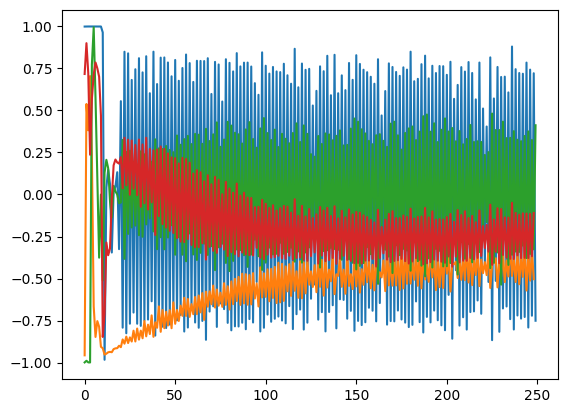

In [25]:
for i in range(actions_pred.shape[-1]):
    plt.plot(actions[:,0,i].detach().cpu().numpy())
    plt.plot(actions_pred[:,i])

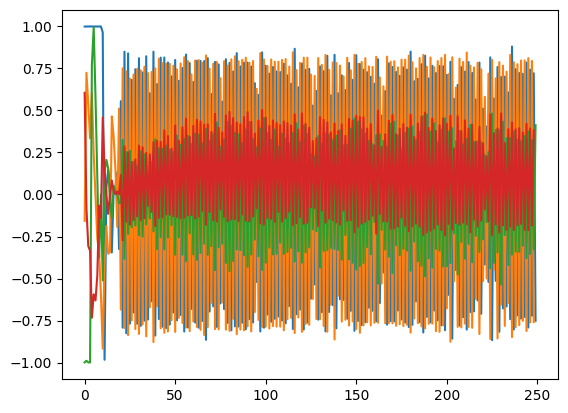

In [61]:
for i in range(actions_pred.shape[-1]):
    plt.plot(actions[:,0,i].detach().cpu().numpy())
    plt.plot(actions_pred[:,i])

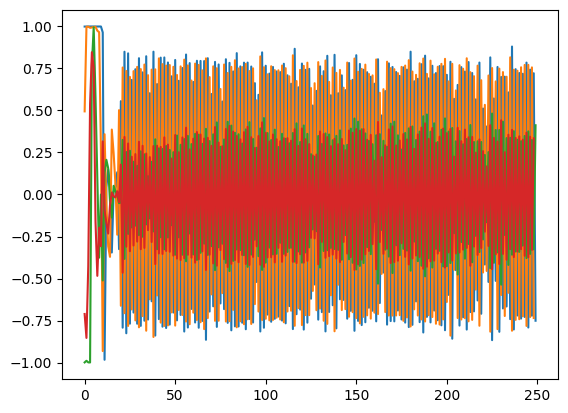

In [39]:
for i in range(actions_pred.shape[-1]):
    plt.plot(actions[:,0,i].detach().cpu().numpy())
    plt.plot(actions_pred[:,i])

In [38]:
image_rec = recon["loc"].detach().cpu().numpy()
image_rec.shape

(249, 1, 3, 64, 64)

In [39]:
from common.visualize_utils import image_postprocess


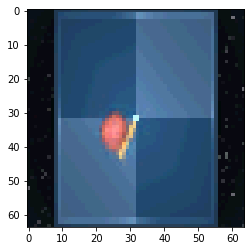

In [42]:
plt.imshow(image_postprocess(image_rec[0,0]))

In [1]:
def f(x, a, b):
    return a * x + b

In [2]:
from ipywidgets import interact
interact(f, x=(-10,10, 1), a=(-10,10, 1), b=(-10,10, 1))

interactive(children=(IntSlider(value=0, description='x', max=10, min=-10), IntSlider(value=0, description='a'…

<function __main__.f(x, a, b)>

In [12]:
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence


#numpy,scipy.statsからnorm,math,matplotlib.pyplotをインポート！
import numpy as np
from scipy.stats import norm
import math
import matplotlib.pyplot as plt

loc1 = 0
scale1 = 1
loc2 = 1
scale2 = 1

def _kl(loc1, scale1, loc2, scale2):
    p1 = Normal(loc1, scale1)
    p2 = Normal(loc2, scale2)
    
    kl_12 = kl_divergence(p1,p2)
    kl_21 = kl_divergence(p2,p1)
    
    #0から100まで、0.01間隔で入ったリストXを作る！
    X = np.arange(-5,5,0.01)
    #確率密度関数にX,平均50、標準偏差20を代入
    Y1 = norm.pdf(X,loc1,scale1)
    Y2 = norm.pdf(X,loc2,scale2)

    #x,yを引数にして、関数の色をr(red)に指定！カラーコードでも大丈夫です！
    plt.plot(X,Y1,color='r')
    plt.plot(X,Y2,color='b')
    plt.show()
    print("KL[p1|p2]:{}, KL[p2|p1]:{}".format(kl_12, kl_21))

In [13]:
from ipywidgets import interact
interact(_kl, loc1=(-10,10, 1), scale1=(0.1,2, 0.1), loc2=(-10,10, 1), scale2=(0.1, 2, 0.1))

interactive(children=(IntSlider(value=0, description='loc1', max=10, min=-10), FloatSlider(value=1.0, descript…

<function __main__._kl(loc1, scale1, loc2, scale2)>

In [16]:
import numpy as np
a = np.arange(10)
print(a)

[0 1 2 3 4 5 6 7 8 9]


In [37]:
T = 4
t = 3

t_end = -T+t+2 if T-t>1 else None
a[t+1:t_end]

array([4, 5, 6, 7, 8, 9])

In [21]:
-T+t+1

-1

In [23]:
a[:-(T-1)]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

# Imagination

In [174]:
t = -1
t_imag_start = 20

ht = [state["beliefs"][t_imag_start]]
# st = [state["posterior_states"][t_imag_start]]
st = [state["posterior_means"][t_imag_start]]
at = []

horizon_imagination = 500
for t in range(horizon_imagination):
    action = model.planner.get_action(ht[t], st[t],det=True)
    at.append(action)
    belief, _, prior_mean, _ = model.rssm.transition_model(st[t], action.unsqueeze(dim=0), ht[t], det=True)
    ht.append(belief.squeeze(dim=0))
    # st.append(prior_state.squeeze(dim=0))
    st.append(prior_mean.squeeze(dim=0))

In [175]:
h_t = torch.stack(ht)
s_t = torch.stack(st)

action_imag = torch.stack(at)#.detach().cpu().numpy()

In [176]:
recon_imag = model.rssm.observation_model(h_t=h_t, s_t=s_t)
# recon_imag["image_vertical_high_resolution"]["loc"].shape

In [177]:
if "d_pose" in pose_name:
    dx_imag = action_imag[:,:,0].detach().cpu().numpy()[:,0]
    dy_imag = action_imag[:,:,1].detach().cpu().numpy()[:,0]
    dz_imag = action_imag[:,:,2].detach().cpu().numpy()[:,0]
    
    x_imag = np.zeros_like(dx_imag)+x_obs[t_imag_start]
    y_imag = np.zeros_like(dy_imag)+y_obs[t_imag_start]
    z_imag = np.zeros_like(dz_imag)+z_obs[t_imag_start]
    for t in range(len(dx_imag)):
        x_imag[t:] += dx_imag[t]
        y_imag[t:] += dy_imag[t]
        z_imag[t:] += dz_imag[t]
    
else:
    x_imag = recon_imag[pose_name]["loc"][:,:,0].detach().cpu().numpy()[:,0]
    y_imag = recon_imag[pose_name]["loc"][:,:,1].detach().cpu().numpy()[:,0]
    z_imag = recon_imag[pose_name]["loc"][:,:,2].detach().cpu().numpy()[:,0]
    

In [178]:
# x_imag = recon_imag[pose_name]["loc"][:,:,0].detach().cpu().numpy()[:,0]
# y_imag = recon_imag[pose_name]["loc"][:,:,1].detach().cpu().numpy()[:,0]
# z_imag = recon_imag[pose_name]["loc"][:,:,2].detach().cpu().numpy()[:,0]

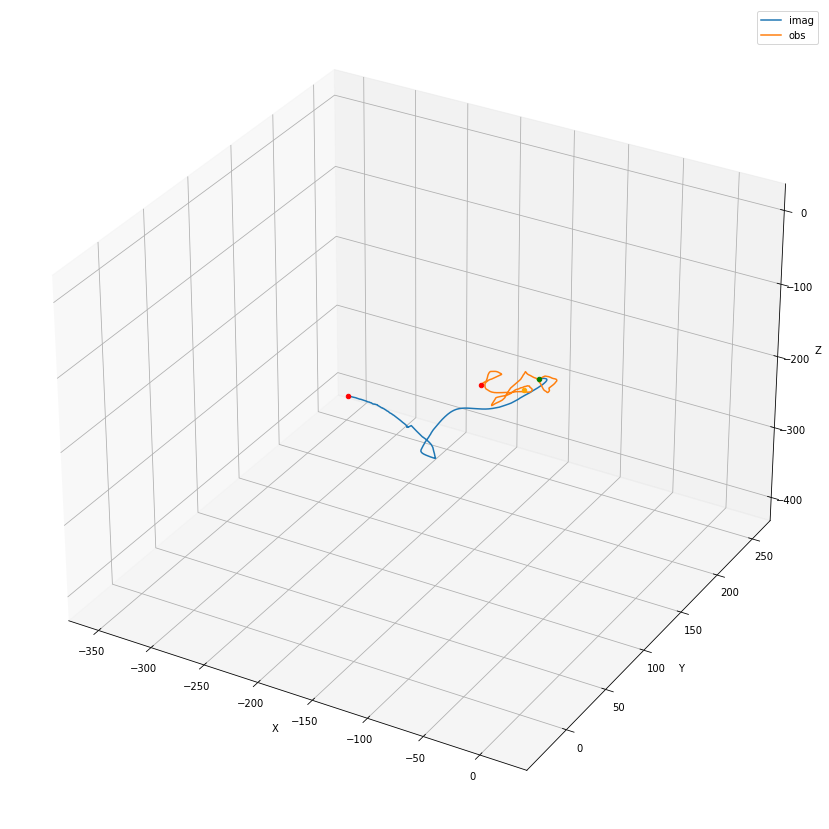

In [179]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_imag, y_imag, z_imag, label="imag")
ax.plot(x_obs[t_imag_start:t_imag_start+len(x_imag)], y_obs[t_imag_start:t_imag_start+len(x_imag)], z_obs[t_imag_start:t_imag_start+len(x_imag)], label="obs")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# ax.set_xlim([-2,2])
# ax.set_ylim([-3,1])
# ax.set_zlim([0,4])

ax.scatter(x_imag[0], y_imag[0], z_imag[0], color="green")
ax.scatter(x_imag[-1], y_imag[-1], z_imag[-1], color="red")

ax.scatter(x_obs[0], y_obs[0], z_obs[0], color="orange")
ax.scatter(x_obs[-1], y_obs[-1], z_obs[-1], color="red")

plt.legend()
plt.show()

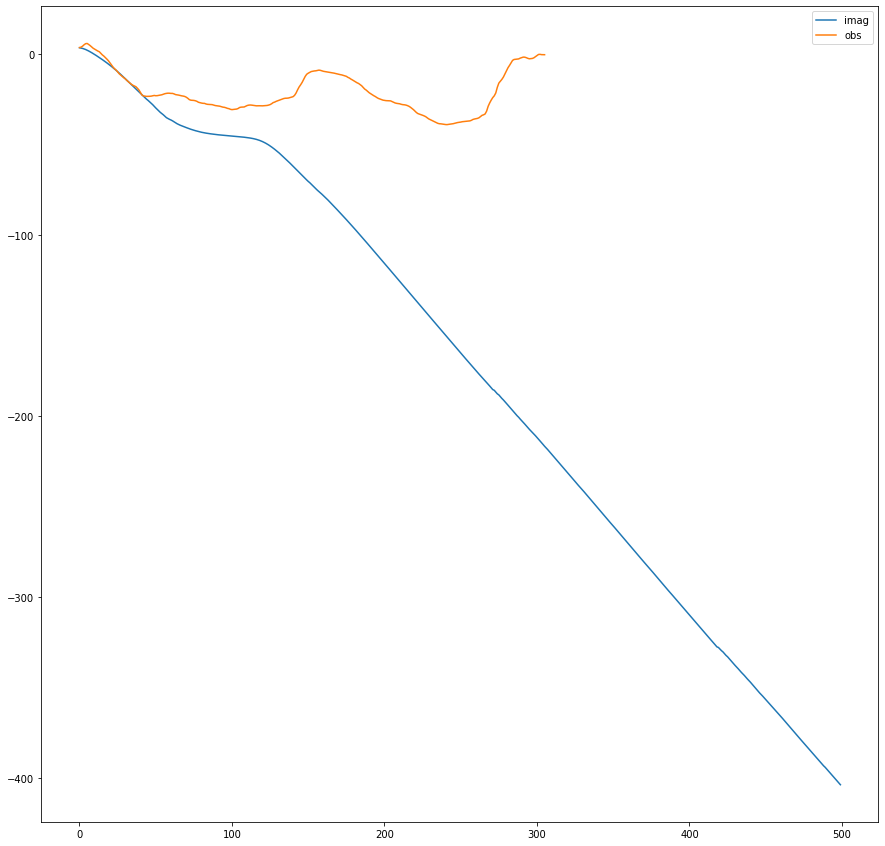

In [180]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.plot(z_imag, label="imag")
ax.plot(z_obs[t_imag_start:t_imag_start+len(x_imag)],label="obs")
# ax.set_xlabel("X")
# ax.set_ylabel("Y")

plt.legend()
plt.show()

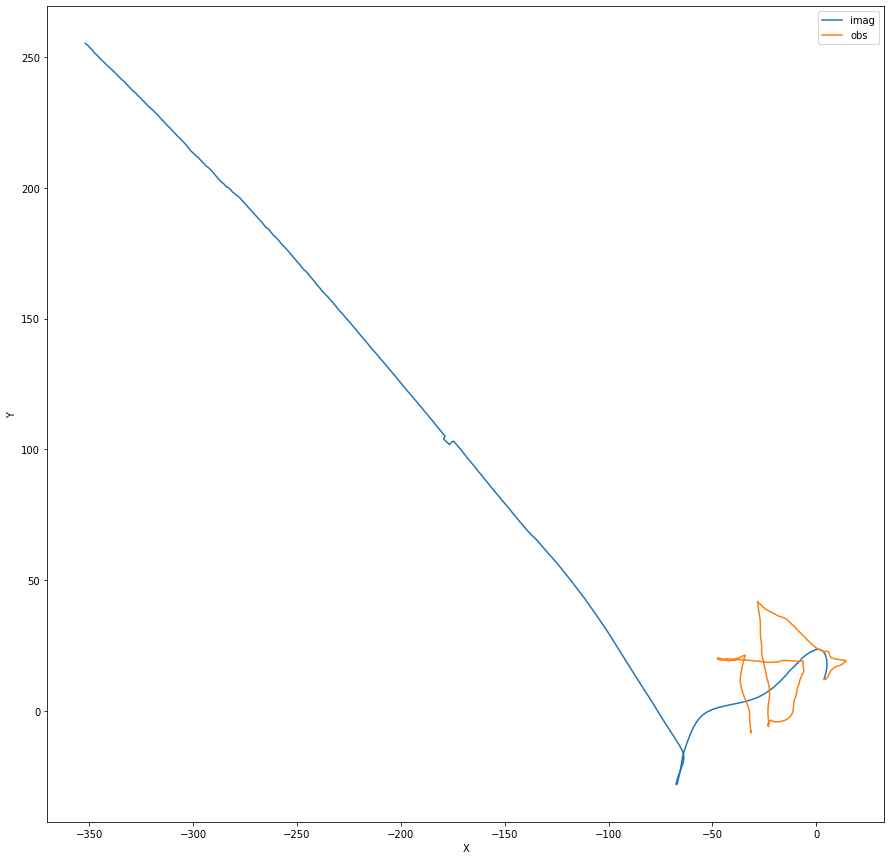

In [181]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.plot(x_imag, y_imag, label="imag")
ax.plot(x_obs[t_imag_start:t_imag_start+len(x_imag)], y_obs[t_imag_start:t_imag_start+len(x_imag)], label="obs")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.legend()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1017.62it/s]


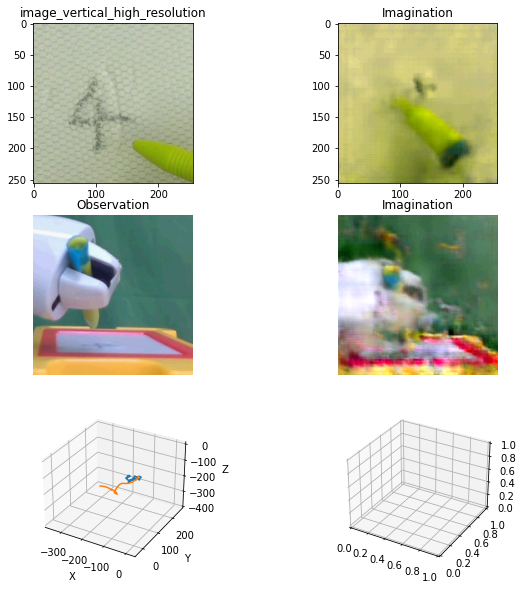

In [182]:
from common.visualize_utils import image_postprocess, plot_pca_traj
from IPython import display


fig = plt.figure(figsize=(10,10))
h_graph = 3
w_graph = 2
ax1 = fig.add_subplot(h_graph, w_graph, 1)
ax2 = fig.add_subplot(h_graph, w_graph, 2)
ax3 = fig.add_subplot(h_graph, w_graph, 3)
ax4 = fig.add_subplot(h_graph, w_graph, 4)
ax5 = fig.add_subplot(h_graph, w_graph, 5, projection='3d')
ax6 = fig.add_subplot(h_graph, w_graph, 6, projection='3d')

n_frame = horizon_imagination
# n_frame = 100

xlim = (-2, 2)
ylim = (-2, 2)
zlim = (-2, 2)


ax3.axis("off")
ax4.axis("off")

dt = 2

artists = []
for t in range(0, n_frame, dt):
    t_obs = t_imag_start+t
    
    if t_obs >= len(observations["image_vertical_high_resolution"]):
        t_obs = len(observations["image_vertical_high_resolution"])-1
    im = observations["image_vertical_high_resolution"][t_obs, 0][[2,1,0]]
    im1 = ax1.imshow(image_postprocess(im))
    ax1.set_title("image_vertical_high_resolution")
    
    im = recon_imag["image_vertical_high_resolution"]["loc"][t, 0][[2,1,0]]
    im2 = ax2.imshow(image_postprocess(im))
    ax2.set_title("Imagination")
    
    
    if t_obs >= len(observations["image_horizon_high_resolution"]):
        t_obs = len(observations["image_horizon_high_resolution"])-1
    im = observations["image_horizon_high_resolution"][t_obs, 0][[2,1,0]]
    im3 = ax3.imshow(image_postprocess(im))
    ax3.set_title("Observation")
    
    im = recon_imag["image_horizon_high_resolution"]["loc"][t, 0][[2,1,0]]
    im4 = ax4.imshow(image_postprocess(im))
    ax4.set_title("Imagination")
    
    ax5.set_xlabel("X")
    ax5.set_ylabel("Y")
    ax5.set_zlabel("Z")
    # ax5.set_xlim([-2,2])
    # ax5.set_ylim([-3,1])
    # ax5.set_zlim([0,4])
    
    im5_1 = ax5.plot(x_obs[t_imag_start:t_imag_start+t], y_obs[t_imag_start:t_imag_start+t], z_obs[t_imag_start:t_imag_start+t], color="tab:blue")
    # ax5.scatter(x_obs[0], y_obs[0], z_obs[0], color="green")
    # ax5.scatter(x_obs[t], y_obs[t], z_obs[t], color="red")
    im5_2 = ax5.plot(x_imag[:t], y_imag[:t], z_imag[:t], color="tab:orange")
    # ax5.scatter(x_rec[0], y_rec[0], z_rec[0], color="green")
    # im5 = ax5.scatter(x_rec[t], y_rec[t], z_rec[t], color="red")
    
        
    artists.append([im1, im2, im3,im4]+im5_1+im5_2)

# 4. アニメーション化
anim = ArtistAnimation(fig, tqdm(artists), interval=100*dt)
save_file_name = "imagination.mp4"
anim.save(save_file_name, writer='ffmpeg')
plt.show()